In [1]:
import os
import sys
import json
import time
import math
import gspread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.lines import Line2D
from matplotlib.colorbar import Colorbar
import seaborn as sns
from scipy import integrate, signal, stats, fftpack
from glob import glob
from datetime import date
import mne
from mne.time_frequency import tfr_array_morlet
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_stim_events, get_evoked_traces, find_nearest_ind

from PCIst.PCIst.pci_st import calc_PCIst, dimensionality_reduction

In [4]:
%matplotlib notebook

#### Functions

In [5]:
def get_stim_event_inds(stim_table, stim_type, stim_param, sweep, trials='resting'):
    if trials == 'resting':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == True)
        ].index.values
    elif trials == 'running':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == False)
        ].index.values
    else:
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True)
        ].index.values

#### Load metadata from EEG_exp info

In [6]:
vismetadata = pd.read_excel(
    r'C:\Users\lesliec\OneDrive - Allen Institute\EEG_exp info.xlsx',
    sheet_name='Visual Experiments',
    dtype=str
)
vismetadata = vismetadata.astype({'Bad chs': str})
# vismetadata.head()

In [7]:
# state_colors = {
#     'awake': (120/255, 156/255, 74/255),
#     'anesthetized': (130/255, 122/255, 163/255),
#     'recovery': (93/255, 167/255, 229/255)
# }

state_colors = {
    'resting': 'firebrick',
    'running': 'forestgreen',
    'isoflurane': 'royalblue',
    'urethane': 'teal',
    'burst_suppression': 'dimgray',
}

### Load subjects list from .json file

In [8]:
with open(r'C:\Users\lesliec\OneDrive - Allen Institute\data\BEST_visualEEGLFPgrant_subjects_states.json') as subjects_file:
    multi_sub_dict = json.load(subjects_file)

In [9]:
for mouse_num, mdata in multi_sub_dict.items():
    print(' {}'.format(mouse_num))
    mdata['exp'] = EEGexp(mdata['data_loc'], preprocess=False, make_stim_csv=False)
    print('')

 551397
Experiment type: electrical and sensory stimulation
Body camera file not found.
Pupil camera file not found.

 569069
Experiment type: electrical and sensory stimulation

 575100
Experiment type: electrical and sensory stimulation
SomnoSuite log file not found.

 571620
Experiment type: electrical and sensory stimulation
SomnoSuite log file not found.

 586466
Experiment type: electrical and sensory stimulation
SomnoSuite log file not found.

 590480a
Experiment type: electrical and sensory stimulation
SomnoSuite log file not found.



In [10]:
plotsdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\LFP_EEG_grant'

# Load EEG and V1 LFP traces for correlation analysis

In [11]:
## parameters ##
downsampleEEG = True
subsampling_factor = 2
apply_car = True
chtrials = 'resting' # choose: 'resting', 'running', or 'all'
test_states = ['awake', 'isoflurane', 'urethane', 'burst_suppression']

In [12]:
start = time.time()
vis_EEG_traces = {}
vis_LFP_traces = {}
vis_LFP_info = {}
for mouse_num, mdata in multi_sub_dict.items():
    print('{}'.format(mouse_num))
    evoked_data_folder = os.path.join(mdata['exp'].data_folder, 'evoked_data')
    
    ## Load LFP info and traces ##
    with open(os.path.join(evoked_data_folder, 'evokedLFPinfo.json')) as info_file:
        LFPinfo = json.load(info_file)
    if 'VIS' not in LFPinfo.keys():
        print(' No Npx data from VIS, not analyzing.\n')
        continue
    LFP_event_ts = np.load(os.path.join(evoked_data_folder, 'evokedLFPtimestamps.npy'))
    all_LFP_traces = np.load(os.path.join(evoked_data_folder, 'VIS_evokedLFPtraces.npy'))
    
    if mdata['exp'].mouse not in vis_EEG_traces.keys():
        vis_EEG_traces[mdata['exp'].mouse] = {}
        vis_LFP_traces[mdata['exp'].mouse] = {}
        vis_LFP_info[mdata['exp'].mouse] = LFPinfo['VIS']
    
    ## Grab exp metadata from Zap_Zip-log_exp ##
    exp_meta = vismetadata[vismetadata['Mouse'] == mouse_num].squeeze()
    badchstr = exp_meta['Bad chs'].replace(' ','')
    bad_chs = []
    for char in badchstr.split(','):
        if char.isdecimal():
            bad_chs.append(int(char))
    
    ## Load stim log, includes running speed info ##
    stim_log = pd.read_csv(mdata['exp'].stimulus_log_file)

    ## Load EEG traces ##
    all_EEG_traces = np.load(os.path.join(evoked_data_folder, 'event_EEGtraces.npy'))
    EEG_event_timestamps = np.load(os.path.join(evoked_data_folder, 'event_EEGtraces_times.npy'))
    eeg_chs = np.arange(0, all_EEG_traces.shape[1])
    GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])
    if downsampleEEG:
        EEG_event_timestamps = EEG_event_timestamps[::subsampling_factor]
        all_EEG_traces = signal.decimate(all_EEG_traces, subsampling_factor, ftype='iir', axis=0, zero_phase=True)
        
    ## Get evoked traces ##
    print(' Getting evoked EEG and LFP traces...\n')
    for statei in mdata['states'].keys():
        if statei not in test_states:
            continue
        
        sweeps = mdata['states'][statei]
        if not sweeps:
            continue
            
        if statei == 'awake':
            substates = ['resting', 'running']
            for substatei in substates:
                state_event_inds = []
                for sweepi in sweeps:
                    eventinds = get_stim_event_inds(stim_log, 'circle', 'white', sweepi, trials=substatei)
                    if len(eventinds) == 0:
                        continue
                    state_event_inds.append(eventinds)
                state_event_inds = np.concatenate(state_event_inds)
                event_traces = all_EEG_traces[:, :, state_event_inds]
                ## Apply common avg ##
                if apply_car:
                    event_traces = event_traces - np.mean(event_traces[:, GOOD_CHS, :], axis=1)[:,None,:]
                vis_EEG_traces[mdata['exp'].mouse][substatei] = [EEG_event_timestamps, event_traces[:, 4, :]]
                
                vis_LFP_traces[mdata['exp'].mouse][substatei] = [LFP_event_ts, all_LFP_traces[:, :, state_event_inds]]
        else:
            state_event_inds = []
            for sweepi in sweeps:
                eventinds = get_stim_event_inds(stim_log, 'circle', 'white', sweepi, trials=chtrials)
                if len(eventinds) == 0:
                    continue
                state_event_inds.append(eventinds)
            state_event_inds = np.concatenate(state_event_inds)
            event_traces = all_EEG_traces[:, :, state_event_inds]
            ## Apply common avg ##
            if apply_car:
                event_traces = event_traces - np.mean(event_traces[:, GOOD_CHS, :], axis=1)[:,None,:]
            vis_EEG_traces[mdata['exp'].mouse][statei] = [EEG_event_timestamps, event_traces[:, 4, :]]
            
            vis_LFP_traces[mdata['exp'].mouse][statei] = [LFP_event_ts, all_LFP_traces[:, :, state_event_inds]]
            
    del stim_log, all_EEG_traces, EEG_event_timestamps
    del LFPinfo, all_LFP_traces, LFP_event_ts
end = time.time()
print('Time to load all subjects: {:.2f} mins'.format((end-start)/60))

551397
 No Npx data from VIS, not analyzing.

569069
 Getting evoked EEG and LFP traces...

575100
 Getting evoked EEG and LFP traces...

571620
 Getting evoked EEG and LFP traces...

586466
 No Npx data from VIS, not analyzing.

590480a
 Getting evoked EEG and LFP traces...

Time to load all subjects: 5.00 mins


## Explore correlation for one subject

<IPython.core.display.Javascript object>


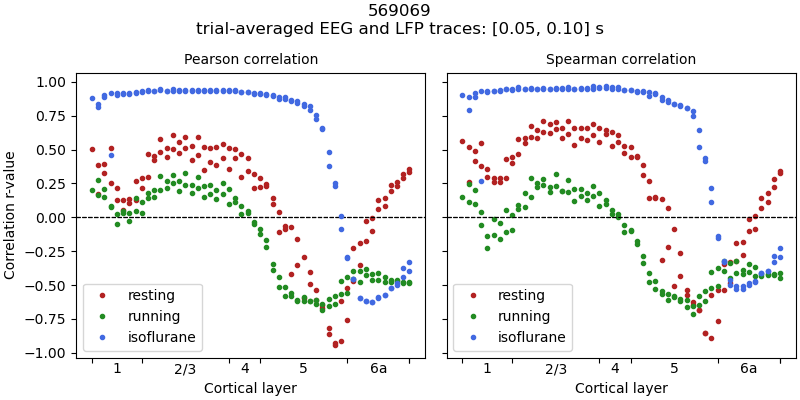

In [78]:
mousei = '569069'
xlabel_layers = True
corr_win = [0.05, 0.1]

fig, axs = plt.subplots(1, 2, figsize=(8,4), sharex=True, sharey=True, constrained_layout=True)

LFPinfo = vis_LFP_info[mousei]
borders = [False]
labels = [LFPinfo['ch_areas'][0][[i for i, c in enumerate(LFPinfo['ch_areas'][0]) if c.isdigit()][0]:]]
for ii in range(1, len(LFPinfo['ch_areas'])):
    if LFPinfo['ch_areas'][ii] == LFPinfo['ch_areas'][ii-1]:
        borders.append(True)
    else:
        borders.append(False)
        labels.append(LFPinfo['ch_areas'][ii][[i for i, c in enumerate(LFPinfo['ch_areas'][ii]) if c.isdigit()][0]:])
borderlocs = np.hstack((np.array(LFPinfo['ch_depths'])[np.nonzero(np.invert(borders))[0]], LFPinfo['ch_depths'][-1]))

for statei in vis_EEG_traces[mousei].keys():
    EEGtime = vis_EEG_traces[mousei][statei][0]
    EEGtrace = np.mean(vis_EEG_traces[mousei][statei][1], axis=1)
    LFPtime = vis_LFP_traces[mousei][statei][0]
    LFPtraces = np.mean(vis_LFP_traces[mousei][statei][1], axis=2)
    
    EEGinds = np.nonzero((EEGtime > corr_win[0]) & (EEGtime < corr_win[1]))[0]
    LFPinds = np.nonzero((LFPtime > corr_win[0]) & (LFPtime < corr_win[1]))[0]
    
    pearson_r = np.zeros((LFPtraces.shape[1]), dtype=float)
    pearson_p = np.zeros((LFPtraces.shape[1]), dtype=float)
    spearman_r = np.zeros((LFPtraces.shape[1]), dtype=float)
    spearman_p = np.zeros((LFPtraces.shape[1]), dtype=float)
    for ii in range(LFPtraces.shape[1]):
        pearson_r[ii], pearson_p[ii] = stats.pearsonr(EEGtrace[EEGinds], LFPtraces[LFPinds, ii])
        spearman_r[ii], spearman_p[ii] = stats.spearmanr(EEGtrace[EEGinds], LFPtraces[LFPinds, ii])
        
    axs[0].set_title('Pearson correlation')
    axs[0].axhline(0, color='k', linewidth=0.8, linestyle='dashed')
    axs[0].plot(LFPinfo['ch_depths'], pearson_r, color=state_colors[statei], linestyle='none', marker='.', label=statei)
    axs[0].legend()
    axs[0].set_ylabel('Correlation r-value')
    
    axs[1].set_title('Spearman correlation')
    axs[1].axhline(0, color='k', linewidth=0.8, linestyle='dashed')
    axs[1].plot(LFPinfo['ch_depths'], spearman_r, color=state_colors[statei], linestyle='none', marker='.', label=statei)
    axs[1].legend()
    
if xlabel_layers:
    axs[0].set_xticks(borderlocs)
    axs[0].set_xticklabels('')
    axs[0].set_xticks(borderlocs[:-1] + np.diff(borderlocs)/2, minor=True)
    axs[0].set_xticklabels(labels, minor=True, fontsize=10)
    axs[0].tick_params(which='minor', length=0)
    axs[1].tick_params(which='minor', length=0)
    axs[0].set_xlabel('Cortical layer')
    axs[1].set_xlabel('Cortical layer')
else:
    axs[0].set_xlabel('Depth from brain surface (\u03bcm)')
    axs[1].set_xlabel('Depth from brain surface (\u03bcm)')
    
plt.suptitle('{}\ntrial-averaged EEG and LFP traces: [{:.2f}, {:.2f}] s'.format(mousei, corr_win[0], corr_win[1]))
    
## Save ##
figname = 'EEG-LFP_corr_P-Sp_{}_states_{:.2f}-{:.2f}.png'.format(mousei, corr_win[0], corr_win[1])
fig.savefig(os.path.join(plotsdir, figname), transparent=False)

#### Average across states

<IPython.core.display.Javascript object>


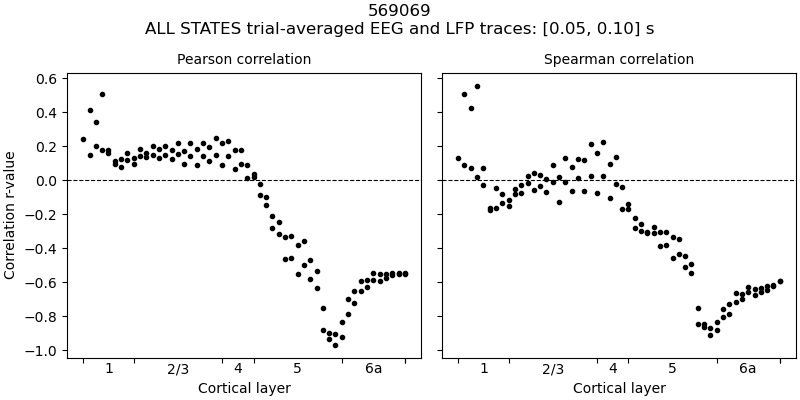

In [79]:
# mousei = '569069'
# xlabel_layers = True
# corr_win = [0, 2.0]

fig, axs = plt.subplots(1, 2, figsize=(8,4), sharex=True, sharey=True, constrained_layout=True)

LFPinfo = vis_LFP_info[mousei]
borders = [False]
labels = [LFPinfo['ch_areas'][0][[i for i, c in enumerate(LFPinfo['ch_areas'][0]) if c.isdigit()][0]:]]
for ii in range(1, len(LFPinfo['ch_areas'])):
    if LFPinfo['ch_areas'][ii] == LFPinfo['ch_areas'][ii-1]:
        borders.append(True)
    else:
        borders.append(False)
        labels.append(LFPinfo['ch_areas'][ii][[i for i, c in enumerate(LFPinfo['ch_areas'][ii]) if c.isdigit()][0]:])
borderlocs = np.hstack((np.array(LFPinfo['ch_depths'])[np.nonzero(np.invert(borders))[0]], LFPinfo['ch_depths'][-1]))

allEEGtraces = []
allLFPtraces = []
for statei in vis_EEG_traces[mousei].keys():
    EEGtime = vis_EEG_traces[mousei][statei][0]
    allEEGtraces.append(vis_EEG_traces[mousei][statei][1])
    LFPtime = vis_LFP_traces[mousei][statei][0]
    allLFPtraces.append(vis_LFP_traces[mousei][statei][1])
    
EEGtrace = np.mean(np.concatenate(allEEGtraces, axis=1), axis=1)
LFPtraces = np.mean(np.concatenate(allLFPtraces, axis=2), axis=2)
    
EEGinds = np.nonzero((EEGtime > corr_win[0]) & (EEGtime < corr_win[1]))[0]
LFPinds = np.nonzero((LFPtime > corr_win[0]) & (LFPtime < corr_win[1]))[0]
    
pearson_r = np.zeros((LFPtraces.shape[1]), dtype=float)
pearson_p = np.zeros((LFPtraces.shape[1]), dtype=float)
spearman_r = np.zeros((LFPtraces.shape[1]), dtype=float)
spearman_p = np.zeros((LFPtraces.shape[1]), dtype=float)
for ii in range(LFPtraces.shape[1]):
    pearson_r[ii], pearson_p[ii] = stats.pearsonr(EEGtrace[EEGinds], LFPtraces[LFPinds, ii])
    spearman_r[ii], spearman_p[ii] = stats.spearmanr(EEGtrace[EEGinds], LFPtraces[LFPinds, ii])
        
axs[0].set_title('Pearson correlation')
axs[0].axhline(0, color='k', linewidth=0.8, linestyle='dashed')
axs[0].plot(LFPinfo['ch_depths'], pearson_r, color='k', linestyle='none', marker='.')
# axs[0].legend()
axs[0].set_ylabel('Correlation r-value')

axs[1].set_title('Spearman correlation')
axs[1].axhline(0, color='k', linewidth=0.8, linestyle='dashed')
axs[1].plot(LFPinfo['ch_depths'], spearman_r, color='k', linestyle='none', marker='.')
# axs[1].legend()
    
if xlabel_layers:
    axs[0].set_xticks(borderlocs)
    axs[0].set_xticklabels('')
    axs[0].set_xticks(borderlocs[:-1] + np.diff(borderlocs)/2, minor=True)
    axs[0].set_xticklabels(labels, minor=True, fontsize=10)
    axs[0].tick_params(which='minor', length=0)
    axs[1].tick_params(which='minor', length=0)
    axs[0].set_xlabel('Cortical layer')
    axs[1].set_xlabel('Cortical layer')
else:
    axs[0].set_xlabel('Depth from brain surface (\u03bcm)')
    axs[1].set_xlabel('Depth from brain surface (\u03bcm)')
    
plt.suptitle('{}\nALL STATES trial-averaged EEG and LFP traces: [{:.2f}, {:.2f}] s'.format(mousei, corr_win[0], corr_win[1]))
    
## Save ##
figname = 'EEG-LFP_corr_P-Sp_{}_allstates_{:.2f}-{:.2f}.png'.format(mousei, corr_win[0], corr_win[1])
fig.savefig(os.path.join(plotsdir, figname), transparent=False)

#### Plot one state only

<IPython.core.display.Javascript object>


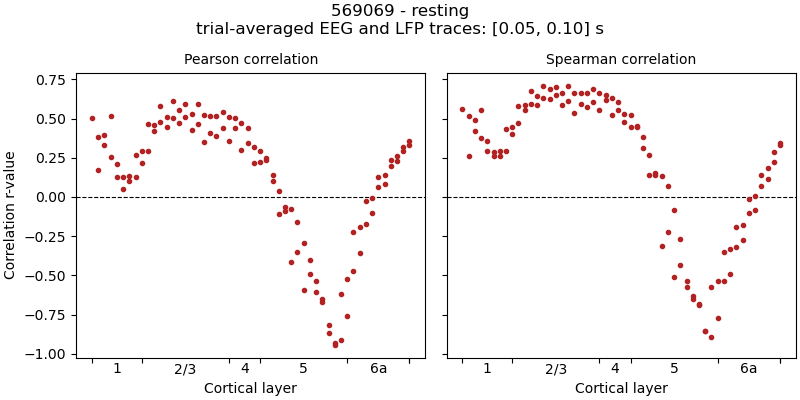

In [80]:
# mousei = '569069'
# xlabel_layers = True
# corr_win = [0.05, 0.1]
statei = 'resting'

fig, axs = plt.subplots(1, 2, figsize=(8,4), sharex=True, sharey=True, constrained_layout=True)

LFPinfo = vis_LFP_info[mousei]
borders = [False]
labels = [LFPinfo['ch_areas'][0][[i for i, c in enumerate(LFPinfo['ch_areas'][0]) if c.isdigit()][0]:]]
for ii in range(1, len(LFPinfo['ch_areas'])):
    if LFPinfo['ch_areas'][ii] == LFPinfo['ch_areas'][ii-1]:
        borders.append(True)
    else:
        borders.append(False)
        labels.append(LFPinfo['ch_areas'][ii][[i for i, c in enumerate(LFPinfo['ch_areas'][ii]) if c.isdigit()][0]:])
borderlocs = np.hstack((np.array(LFPinfo['ch_depths'])[np.nonzero(np.invert(borders))[0]], LFPinfo['ch_depths'][-1]))

EEGtime = vis_EEG_traces[mousei][statei][0]
EEGtrace = np.mean(vis_EEG_traces[mousei][statei][1], axis=1)
LFPtime = vis_LFP_traces[mousei][statei][0]
LFPtraces = np.mean(vis_LFP_traces[mousei][statei][1], axis=2)

EEGinds = np.nonzero((EEGtime > corr_win[0]) & (EEGtime < corr_win[1]))[0]
LFPinds = np.nonzero((LFPtime > corr_win[0]) & (LFPtime < corr_win[1]))[0]

pearson_r = np.zeros((LFPtraces.shape[1]), dtype=float)
pearson_p = np.zeros((LFPtraces.shape[1]), dtype=float)
spearman_r = np.zeros((LFPtraces.shape[1]), dtype=float)
spearman_p = np.zeros((LFPtraces.shape[1]), dtype=float)
for ii in range(LFPtraces.shape[1]):
    pearson_r[ii], pearson_p[ii] = stats.pearsonr(EEGtrace[EEGinds], LFPtraces[LFPinds, ii])
    spearman_r[ii], spearman_p[ii] = stats.spearmanr(EEGtrace[EEGinds], LFPtraces[LFPinds, ii])

axs[0].set_title('Pearson correlation')
axs[0].axhline(0, color='k', linewidth=0.8, linestyle='dashed')
axs[0].plot(LFPinfo['ch_depths'], pearson_r, color=state_colors[statei], linestyle='none', marker='.', label=statei)
axs[0].set_ylabel('Correlation r-value')

axs[1].set_title('Spearman correlation')
axs[1].axhline(0, color='k', linewidth=0.8, linestyle='dashed')
axs[1].plot(LFPinfo['ch_depths'], spearman_r, color=state_colors[statei], linestyle='none', marker='.', label=statei)
    
if xlabel_layers:
    axs[0].set_xticks(borderlocs)
    axs[0].set_xticklabels('')
    axs[0].set_xticks(borderlocs[:-1] + np.diff(borderlocs)/2, minor=True)
    axs[0].set_xticklabels(labels, minor=True, fontsize=10)
    axs[0].tick_params(which='minor', length=0)
    axs[1].tick_params(which='minor', length=0)
    axs[0].set_xlabel('Cortical layer')
    axs[1].set_xlabel('Cortical layer')
else:
    axs[0].set_xlabel('Depth from brain surface (\u03bcm)')
    axs[1].set_xlabel('Depth from brain surface (\u03bcm)')
    
plt.suptitle('{} - {}\ntrial-averaged EEG and LFP traces: [{:.2f}, {:.2f}] s'.format(mousei, statei, corr_win[0], corr_win[1]))
    
## Save ##
figname = 'EEG-LFP_corr_P-Sp_{}_{}_{:.2f}-{:.2f}.png'.format(mousei, statei, corr_win[0], corr_win[1])
fig.savefig(os.path.join(plotsdir, figname), transparent=False)

### Plot all states EEG and LFP traces

<IPython.core.display.Javascript object>


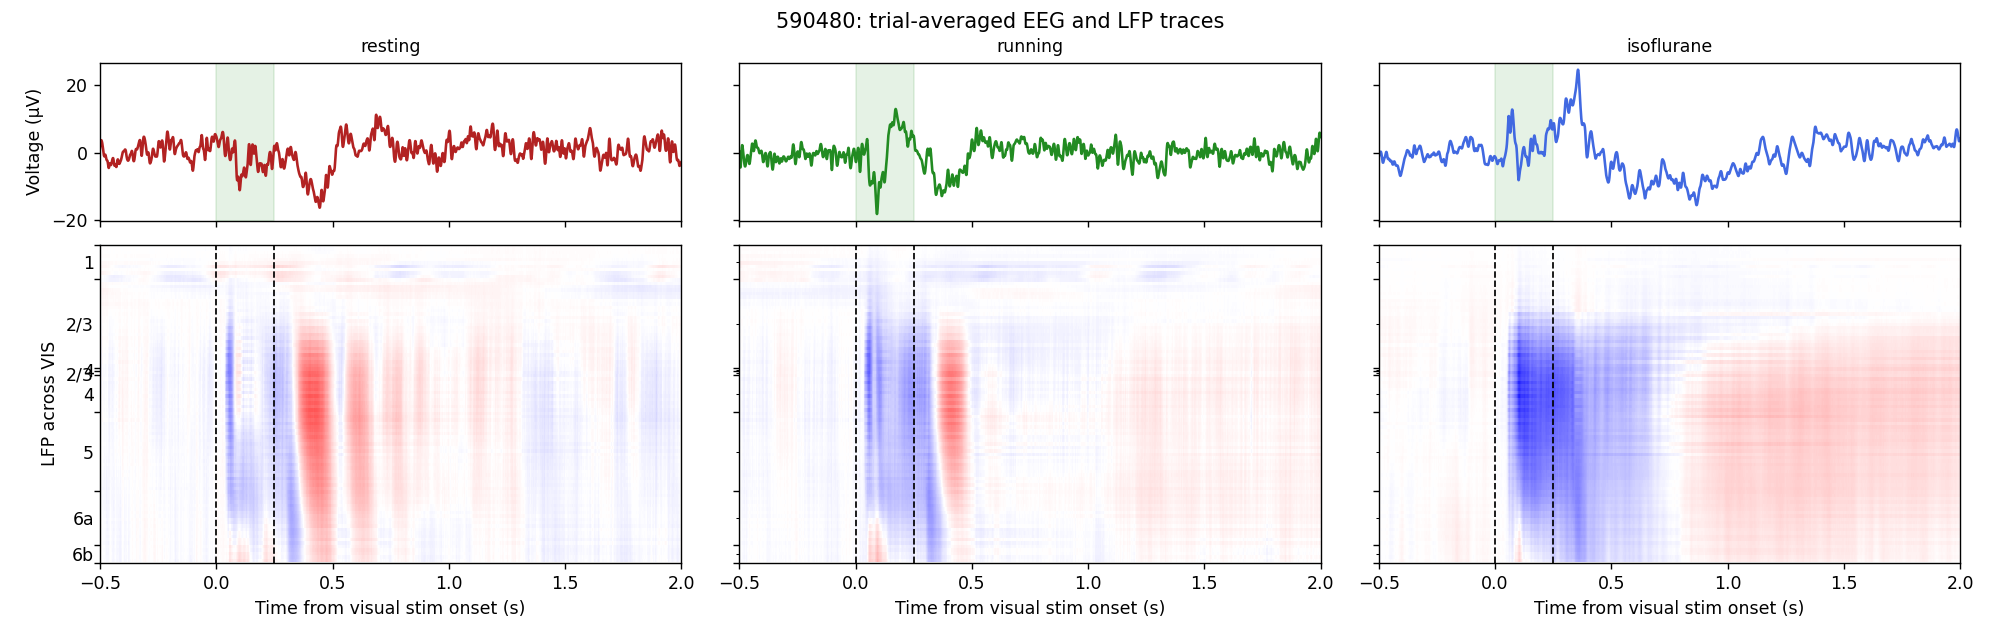

In [36]:
mousei = '590480'
plot_win = [-0.5, 2.0]
lfpv = 500
lfp_layers = True

fig = plt.figure(figsize=(16, 5))
gs = fig.add_gridspec(nrows=2, ncols=1, left=0.05, right=0.98, hspace=0.1, top=0.9, bottom=0.1, height_ratios=[1,2])
eegaxs = gs[0].subgridspec(nrows=1, ncols=len(vis_EEG_traces[mousei]), wspace=0.1).subplots(sharex=True, sharey=True)
lfpaxs = gs[1].subgridspec(nrows=1, ncols=len(vis_EEG_traces[mousei]), wspace=0.1).subplots(sharex=True, sharey=True)

LFPinfo = vis_LFP_info[mousei]
borders = [False]
labels = [LFPinfo['ch_areas'][0][[i for i, c in enumerate(LFPinfo['ch_areas'][0]) if c.isdigit()][0]:]]
for ii in range(1, len(LFPinfo['ch_areas'])):
    if LFPinfo['ch_areas'][ii] == LFPinfo['ch_areas'][ii-1]:
        borders.append(True)
    else:
        borders.append(False)
        labels.append(LFPinfo['ch_areas'][ii][[i for i, c in enumerate(LFPinfo['ch_areas'][ii]) if c.isdigit()][0]:])
borderlocs = np.hstack((np.nonzero(np.invert(borders))[0], len(LFPinfo['ch_areas'])))

for ii, statei in enumerate(vis_EEG_traces[mousei].keys()):
    EEGtime = vis_EEG_traces[mousei][statei][0]
    EEGtrace = np.mean(vis_EEG_traces[mousei][statei][1], axis=1)
    LFPtime = vis_LFP_traces[mousei][statei][0]
    LFPtraces = np.mean(vis_LFP_traces[mousei][statei][1], axis=2)
    
    eegaxs[ii].axvspan(0, 0.25, color='g', alpha=0.1)
    eegaxs[ii].plot(EEGtime, EEGtrace, color=state_colors[statei], linewidth=1.5)
    eegaxs[ii].set_xticklabels([])
    eegaxs[ii].set_title(statei)


    lfpaxs[ii].imshow(
        LFPtraces.T, origin='upper', aspect='auto', cmap='bwr', vmin=-lfpv, vmax=lfpv, interpolation='none',
        extent=[LFPtime[0], LFPtime[-1], LFPtraces.shape[1], 0]
    )
    lfpaxs[ii].axvline(0, color='k', linestyle='dashed', linewidth=1)
    lfpaxs[ii].axvline(0.25, color='k', linestyle='dashed', linewidth=1)
    lfpaxs[ii].set_xlabel('Time from visual stim onset (s)')
    if lfp_layers:
        lfpaxs[ii].set_yticks(borderlocs)
        lfpaxs[ii].set_yticklabels('')
        if ii == 0:
            lfpaxs[ii].set_yticks(borderlocs[:-1] + np.diff(borderlocs)/2, minor=True)
            lfpaxs[ii].set_yticklabels(labels, minor=True, fontsize=10)
            lfpaxs[ii].tick_params(which='minor', length=0)
    
eegaxs[0].set_xlim(plot_win)
eegaxs[0].set_ylabel('Voltage (\u03bcV)')

lfpaxs[0].set_xlim(plot_win)
lfpaxs[0].set_ylabel('LFP across VIS')
    
plt.suptitle('{}: trial-averaged EEG and LFP traces'.format(mousei))
    
## Save ##
figname = 'EEG-LFP_traces_{}_allstates.png'.format(mousei)
fig.savefig(os.path.join(plotsdir, figname), transparent=False)

#### Correlation for one state

In [17]:
mousei = '569069'
statei = 'resting'

EEGtime = vis_EEG_traces[mousei][statei][0]
EEGtrace = vis_EEG_traces[mousei][statei][1]
avgEEG = np.mean(EEGtrace, axis=1)
print(EEGtrace.shape)

LFPinfo = vis_LFP_info[mousei]
LFPtime = vis_LFP_traces[mousei][statei][0]
LFPtraces = vis_LFP_traces[mousei][statei][1]
avgLFP = np.mean(LFPtraces, axis=2)
print(LFPtraces.shape)

(5000, 69)
(5000, 103, 69)


Plot average traces

<IPython.core.display.Javascript object>


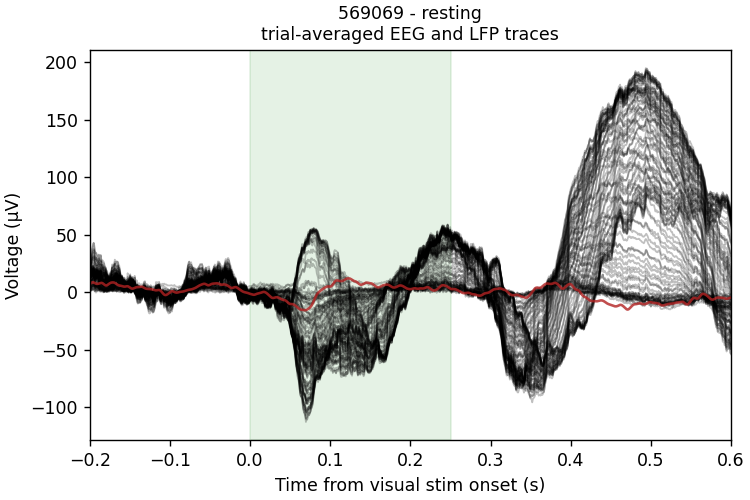

In [18]:
plot_win = [-0.2, 0.6]

fig, ax = plt.subplots(figsize=(6,4), constrained_layout=True)
ax.axvspan(0, 0.25, color='g', alpha=0.1)
ax.plot(LFPtime, np.mean(LFPtraces, axis=2), color='k', linewidth=1, alpha=0.25, label='LFP')
ax.plot(EEGtime, np.mean(EEGtrace, axis=1), color=state_colors[statei], linewidth=1.5, alpha=0.8, label='EEG')
ax.set_xlim(plot_win)
ax.set_xlabel('Time from visual stim onset (s)')
ax.set_ylabel('Voltage (\u03bcV)')
ax.set_title('{} - {}\ntrial-averaged EEG and LFP traces'.format(mousei, statei))

## Save ##
figname = 'EEG-LFP_traces_{}-{}.png'.format(mousei, statei)
# fig.savefig(os.path.join(plotsdir, figname), transparent=False)

#### Pearson vs. Spearman correlations

In [30]:
pearson_r = np.zeros((avgLFP.shape[1]), dtype=float)
pearson_p = np.zeros((avgLFP.shape[1]), dtype=float)
spearman_r = np.zeros((avgLFP.shape[1]), dtype=float)
spearman_p = np.zeros((avgLFP.shape[1]), dtype=float)
for ii in range(avgLFP.shape[1]):
    pearson_r[ii], pearson_p[ii] = stats.pearsonr(avgEEG, avgLFP[:, ii])
    spearman_r[ii], spearman_p[ii] = stats.spearmanr(avgEEG, avgLFP[:, ii])

Correlation time: 0.01 mins


In [36]:
print(len(LFPinfo['ch_depths']))
print(len(pearson_r))

103
103


<IPython.core.display.Javascript object>


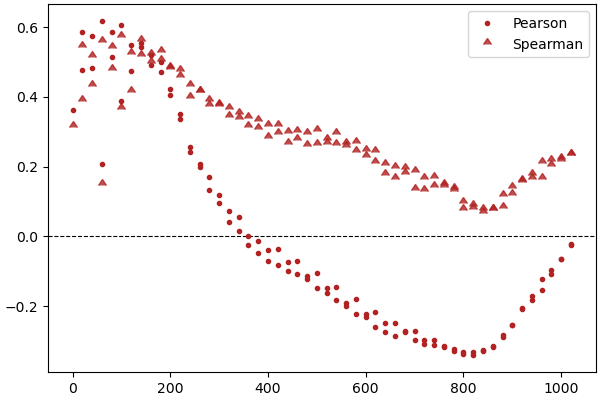

In [43]:
fig, ax = plt.subplots(figsize=(6,4), constrained_layout=True)
ax.axhline(0, color='k', linewidth=0.8, linestyle='dashed')
ax.plot(LFPinfo['ch_depths'], pearson_r, color=state_colors[statei], linestyle='none', marker='.', label='Pearson')
ax.plot(LFPinfo['ch_depths'], spearman_r, color=state_colors[statei], linestyle='none', marker=10, alpha=0.8, label='Spearman')
ax.legend()

Compare baseline to response period: baseline signal has a very high correlation and is not dependent on depth, probably due to the trial-averaged signal.

In [44]:
BLpearson_r = np.zeros((avgLFP.shape[1]), dtype=float)
BLpearson_p = np.zeros((avgLFP.shape[1]), dtype=float)
Rpearson_r = np.zeros((avgLFP.shape[1]), dtype=float)
Rpearson_p = np.zeros((avgLFP.shape[1]), dtype=float)

BLspearman_r = np.zeros((avgLFP.shape[1]), dtype=float)
BLspearman_p = np.zeros((avgLFP.shape[1]), dtype=float)
Rspearman_r = np.zeros((avgLFP.shape[1]), dtype=float)
Rspearman_p = np.zeros((avgLFP.shape[1]), dtype=float)
for ii in range(avgLFP.shape[1]):
    ## Baseline ##
    BLpearson_r[ii], BLpearson_p[ii] = stats.pearsonr(avgEEG[EEGtime < 0], avgLFP[LFPtime < 0, ii])
    BLspearman_r[ii], BLspearman_p[ii] = stats.spearmanr(avgEEG[EEGtime < 0], avgLFP[LFPtime < 0, ii])
    ## Response ##
    Rpearson_r[ii], Rpearson_p[ii] = stats.pearsonr(avgEEG[EEGtime > 0], avgLFP[LFPtime > 0, ii])
    Rspearman_r[ii], Rspearman_p[ii] = stats.spearmanr(avgEEG[EEGtime > 0], avgLFP[LFPtime > 0, ii])

<IPython.core.display.Javascript object>


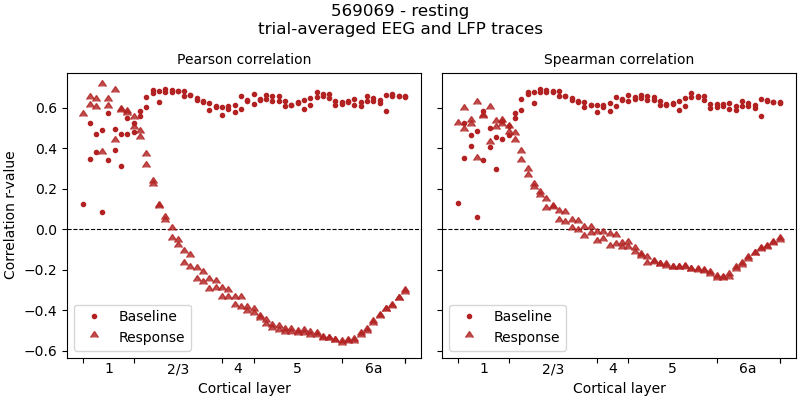

In [83]:
xlabel_layers = True

fig, axs = plt.subplots(1, 2, figsize=(8,4), sharex=True, sharey=True, constrained_layout=True)
axs[0].set_title('Pearson correlation')
axs[0].axhline(0, color='k', linewidth=0.8, linestyle='dashed')
axs[0].plot(LFPinfo['ch_depths'], BLpearson_r, color=state_colors[statei], linestyle='none', marker='.', label='Baseline')
axs[0].plot(LFPinfo['ch_depths'], Rpearson_r, color=state_colors[statei], linestyle='none', marker=10, alpha=0.8, label='Response')
axs[0].legend()
axs[0].set_ylabel('Correlation r-value')

if xlabel_layers:
    borders = [False]
    labels = [LFPinfo['ch_areas'][0][[i for i, c in enumerate(LFPinfo['ch_areas'][0]) if c.isdigit()][0]:]]
    for ii in range(1, len(LFPinfo['ch_areas'])):
        if LFPinfo['ch_areas'][ii] == LFPinfo['ch_areas'][ii-1]:
            borders.append(True)
        else:
            borders.append(False)
            labels.append(LFPinfo['ch_areas'][ii][[i for i, c in enumerate(LFPinfo['ch_areas'][ii]) if c.isdigit()][0]:])
    borderlocs = np.hstack((np.array(LFPinfo['ch_depths'])[np.nonzero(np.invert(borders))[0]], LFPinfo['ch_depths'][-1]))
    axs[0].set_xticks(borderlocs)
    axs[0].set_xticklabels('')
    axs[0].set_xticks(borderlocs[:-1] + np.diff(borderlocs)/2, minor=True)
    axs[0].set_xticklabels(labels, minor=True, fontsize=10)
    axs[0].tick_params(which='minor', length=0)
    axs[1].tick_params(which='minor', length=0)
    axs[0].set_xlabel('Cortical layer')
    axs[1].set_xlabel('Cortical layer')
else:
    axs[0].set_xlabel('Depth from brain surface (\u03bcm)')
    axs[1].set_xlabel('Depth from brain surface (\u03bcm)')
    

axs[1].set_title('Spearman correlation')
axs[1].axhline(0, color='k', linewidth=0.8, linestyle='dashed')
axs[1].plot(LFPinfo['ch_depths'], BLspearman_r, color=state_colors[statei], linestyle='none', marker='.', label='Baseline')
axs[1].plot(LFPinfo['ch_depths'], Rspearman_r, color=state_colors[statei], linestyle='none', marker=10, alpha=0.8, label='Response')
axs[1].legend()

plt.suptitle('{} - {}\ntrial-averaged EEG and LFP traces'.format(mousei, statei))

## Save ##
figname = 'EEG-LFP_corr_P-Sp_{}-{}.png'.format(mousei, statei)
# fig.savefig(os.path.join(plotsdir, figname), transparent=False)

# Load EEG traces for N1 analysis

In [91]:
## parameters ##
apply_car = True
chtrials = 'resting' # choose: 'resting', 'running', or 'all'
test_states = ['awake', 'isoflurane', 'urethane', 'burst_suppression']
test_freqs = np.arange(1., 101., 2.)
test_ncycles = test_freqs / 5.  # different number of cycle per frequency

In [92]:
start = time.time()
vis_EEG_traces = {}
for mouse_num, mdata in multi_sub_dict.items():
    print('{}'.format(mouse_num))
    evoked_data_folder = os.path.join(mdata['exp'].data_folder, 'evoked_data')
    
    if mdata['exp'].mouse not in vis_EEG_traces.keys():
        vis_EEG_traces[mdata['exp'].mouse] = {}
    
    ## Grab exp metadata from Zap_Zip-log_exp ##
    exp_meta = vismetadata[vismetadata['Mouse'] == mouse_num].squeeze()
    badchstr = exp_meta['Bad chs'].replace(' ','')
    bad_chs = []
    for char in badchstr.split(','):
        if char.isdecimal():
            bad_chs.append(int(char))
    
    ## Load stim log, includes running speed info ##
    stim_log = pd.read_csv(mdata['exp'].stimulus_log_file)

    ## Load EEG traces ##
    all_EEG_traces = np.load(os.path.join(evoked_data_folder, 'event_EEGtraces.npy'))
    EEG_event_timestamps = np.load(os.path.join(evoked_data_folder, 'event_EEGtraces_times.npy'))
    eeg_chs = np.arange(0, all_EEG_traces.shape[1])
    GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])
    
    ## Get evoked traces ##
    print(' Getting evoked EEG traces...')
    for statei in mdata['states'].keys():
        if statei not in test_states:
            continue
        
        sweeps = mdata['states'][statei]
        if not sweeps:
            continue
            
        if statei == 'awake':
            substates = ['resting', 'running']
            for substatei in substates:
                state_event_inds = []
                for sweepi in sweeps:
                    eventinds = get_stim_event_inds(stim_log, 'circle', 'white', sweepi, trials=substatei)
                    if len(eventinds) == 0:
                        continue
                    state_event_inds.append(eventinds)
                state_event_inds = np.concatenate(state_event_inds)
                event_traces = all_EEG_traces[:, :, state_event_inds]
                ## Apply common avg ##
                if apply_car:
                    event_traces = event_traces - np.mean(event_traces[:, GOOD_CHS, :], axis=1)[:,None,:]
                vis_EEG_traces[mdata['exp'].mouse][substatei] = [EEG_event_timestamps, event_traces[:, 4, :]]
        else:
            state_event_inds = []
            for sweepi in sweeps:
                eventinds = get_stim_event_inds(stim_log, 'circle', 'white', sweepi, trials=chtrials)
                if len(eventinds) == 0:
                    continue
                state_event_inds.append(eventinds)
            state_event_inds = np.concatenate(state_event_inds)
            event_traces = all_EEG_traces[:, :, state_event_inds]
            ## Apply common avg ##
            if apply_car:
                event_traces = event_traces - np.mean(event_traces[:, GOOD_CHS, :], axis=1)[:,None,:]
            vis_EEG_traces[mdata['exp'].mouse][statei] = [EEG_event_timestamps, event_traces[:, 4, :]]
            
    del stim_log, all_EEG_traces, EEG_event_timestamps
end = time.time()
print('Time to load all subjects: {:.2f} mins'.format((end-start)/60))

551397
 Getting evoked EEG traces...
569069
 Getting evoked EEG traces...
575100
 Getting evoked EEG traces...
571620
 Getting evoked EEG traces...
586466
 Getting evoked EEG traces...
590480a
 Getting evoked EEG traces...
Time to load all subjects: 0.64 mins


### Plot example subject (ch4 traces with sem shading)

Add extra bandpass filter

Testing find peaks

## Test rules for find_peaks across states and subjects

In [93]:
pkstates = ['resting', 'running', 'isoflurane']
plot_win = [-0.2, 0.6]
ffreqs = np.array([5, 50])

peak_win = [0.05, 0.25] # Anton suggested searching from 50-250 ms to remove responses that are too early
std_mult = 1 # Anton suggested lowering the threshold to 1 instead of 2

## Collect N1 peak magnitude and latency for all subjects and states

Anton suggests using baseline - 1xSTD as threshold, so we can use the ANOVA test. Also, report N1 magnitude relative to baseline mean (subtraction or ratio??).

In [94]:
all_sub_stats = []
for mousei, statedata in vis_EEG_traces.items():
    for statei in pkstates:
        datai = vis_EEG_traces[mousei][statei]
#         print('{} - {}'.format(mousei, statei))
        timex = datai[0]
        
        ## Apply a bandpass filter ##
        filtb, filta = signal.butter(3, ffreqs/(2500/2), btype='bandpass')
        visch = np.mean(signal.filtfilt(filtb, filta, datai[1], axis=0), axis=1)
        blmean = np.mean(visch[timex < 0])
        blstd = np.std(visch[timex < 0])

        ## Find peaks in peak_win ##
        sinds = np.nonzero((timex > peak_win[0]) & (timex < peak_win[1]))[0]
        npeaks, npkinfo = signal.find_peaks(-visch[sinds], height=blmean + std_mult*blstd)
        if len(npeaks) == 0:
            print('{} - {}: no N1 found')
            all_sub_stats.append([mousei, statei, blmean, np.nan, np.nan])
        else:
            N1ind = npeaks[np.argmin(visch[sinds[npeaks]])]
            all_sub_stats.append(
                [mousei, statei, blmean, npkinfo['peak_heights'][np.argmin(visch[sinds[npeaks]])], timex[sinds[N1ind]]])
N1_df = pd.DataFrame(all_sub_stats, columns=['mouse', 'state', 'baseline_mean', 'N1magnitude', 'N1latency'])

In [95]:
N1_df.tail()

,mouse,state,baseline_mean,N1magnitude,N1latency
13,586466,running,-0.046144,10.807510,0.0748
14,586466,isoflurane,-0.019557,7.284317,0.1232
15,590480,resting,0.036313,7.055823,0.0984
16,590480,running,-0.008417,10.923957,0.0920
17,590480,isoflurane,-0.032624,8.544276,0.1036


In [96]:
N1_df['N1-baseline'] = N1_df['N1magnitude'] - N1_df['baseline_mean']

Significance test between groups? Wilcoxon signed-rank test with stats.wilcoxon OR repeated measures ANOVA

#### Repeated measures ANOVA and pairwise Tukey posthoc tests

In [101]:
## The ANOVA doesn't work if data is missing ##
mag_anova = AnovaRM(data=N1_df, depvar='N1-baseline', subject='mouse', within=['state']).fit().summary()
print(mag_anova)

               Anova
      F Value Num DF  Den DF Pr > F
-----------------------------------
state  5.8726 2.0000 10.0000 0.0206



In [102]:
posthoc = pairwise_tukeyhsd(N1_df['N1-baseline'].values, N1_df['state'])
print(posthoc)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1    group2 meandiff p-adj   lower   upper  reject
---------------------------------------------------------
isoflurane resting   4.0956 0.1328 -1.0752  9.2664  False
isoflurane running    7.743 0.0039  2.5723 12.9138   True
   resting running   3.6474 0.1931 -1.5233  8.8182  False
---------------------------------------------------------


In [103]:
pk_anova = AnovaRM(data=N1_df, depvar='N1latency', subject='mouse', within=['state']).fit().summary()
print(pk_anova)

               Anova
      F Value Num DF  Den DF Pr > F
-----------------------------------
state  5.7307 2.0000 10.0000 0.0220



In [104]:
pkposthoc = pairwise_tukeyhsd(N1_df['N1latency'].values, N1_df['state'])
print(pkposthoc)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1    group2 meandiff p-adj   lower   upper  reject
---------------------------------------------------------
isoflurane resting  -0.0251 0.0486 -0.0501 -0.0001   True
isoflurane running  -0.0316 0.0131 -0.0566 -0.0066   True
   resting running  -0.0065 0.7696 -0.0315  0.0185  False
---------------------------------------------------------


#### SciPy one-way ANOVA

<IPython.core.display.Javascript object>


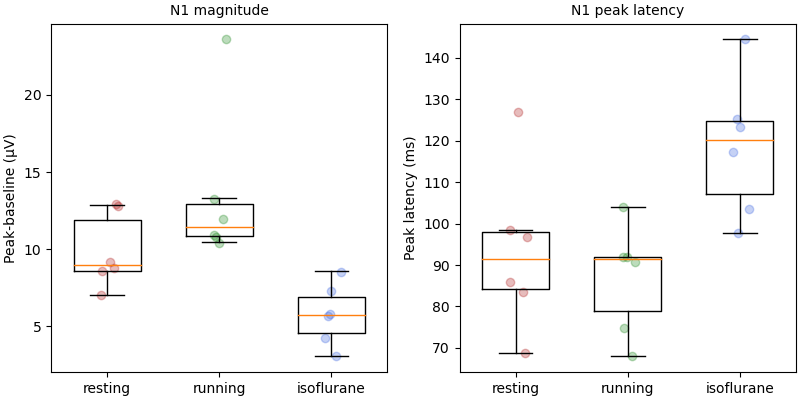

In [98]:
fig, axs = plt.subplots(1, 2, figsize=(8,4), sharex=True, constrained_layout=True)
axs[0].set_title('N1 magnitude')
axs[1].set_title('N1 peak latency')
for ii, statei in enumerate(pkstates):
    statedf = N1_df[N1_df['state'] == statei]
    xs = np.random.normal(ii, 0.05, len(statedf))
    nanmask = ~np.isnan(statedf['N1magnitude'].values)
    
    axs[0].boxplot(
        statedf['N1magnitude'].values[nanmask] - statedf['baseline_mean'].values[nanmask], positions=[ii],
        widths=[0.6], showfliers=False)
    axs[0].scatter(xs, statedf['N1magnitude'].values, c=state_colors[statei], marker='o', alpha=0.3)
    
    axs[1].boxplot(statedf['N1latency'].values[nanmask]*1E3, positions=[ii], widths=[0.6], showfliers=False)
    axs[1].scatter(xs, statedf['N1latency'].values*1E3, c=state_colors[statei], marker='o', alpha=0.3)
    
axs[0].set_ylabel('Peak-baseline (\u03bcV)')
axs[1].set_ylabel('Peak latency (ms)')
axs[0].set_xticks(np.arange(len(pkstates)))
axs[0].set_xticklabels(pkstates)

## Save ##
figname = 'N1peakstats_allbestsubjects.png'
# fig.savefig(os.path.join(plotsdir, figname), transparent=False)

### Plot it with example traces

<IPython.core.display.Javascript object>


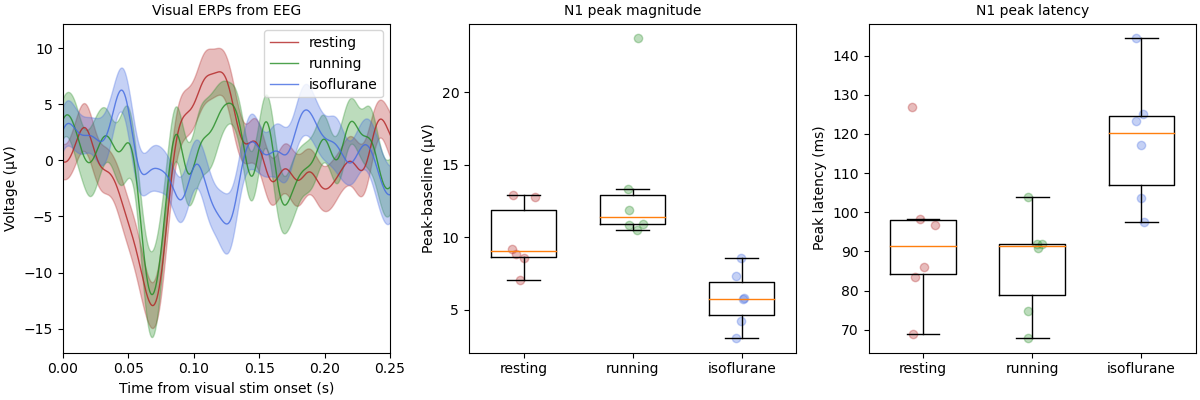

In [99]:
exmouse = '569069'
plot_win = [0, 0.25]
fig, axs = plt.subplots(1, 3, figsize=(12,4), constrained_layout=True)
axs[0].set_title('Visual ERPs from EEG')
axs[1].set_title('N1 peak magnitude')
axs[2].set_title('N1 peak latency')
# axs[0].axvspan(0, 0.25, color='g', alpha=0.1)
for ii, statei in enumerate(pkstates):
    ## plot traces ##
    timex = vis_EEG_traces[exmouse][statei][0]
    filtb, filta = signal.butter(3, ffreqs/(2500/2), btype='bandpass')
    visch = signal.filtfilt(filtb, filta, vis_EEG_traces[exmouse][statei][1], axis=0)
    meansig = np.mean(visch, axis=1)
    semsig = np.std(visch, axis=1) / np.sqrt(visch.shape[1])
    axs[0].plot(timex, meansig, color=state_colors[statei], linewidth=1, alpha=0.8, label=statei)
    axs[0].fill_between(timex, meansig - semsig, meansig + semsig, color=state_colors[statei], alpha=0.3)
    
    statedf = N1_df[N1_df['state'] == statei]
    xs = np.random.normal(ii, 0.05, len(statedf))
    
    axs[1].boxplot(statedf['N1-baseline'].values, positions=[ii], widths=[0.6], showfliers=False)
    axs[1].scatter(xs, statedf['N1-baseline'].values, c=state_colors[statei], marker='o', alpha=0.3)
    
    axs[2].boxplot(statedf['N1latency'].values*1E3, positions=[ii], widths=[0.6], showfliers=False)
    axs[2].scatter(xs, statedf['N1latency'].values*1E3, c=state_colors[statei], marker='o', alpha=0.3)

axs[0].set_xlim(plot_win)
axs[0].set_ylabel('Voltage (\u03bcV)')
axs[0].set_xlabel('Time from visual stim onset (s)')
axs[0].legend()
axs[1].set_ylabel('Peak-baseline (\u03bcV)')
axs[2].set_ylabel('Peak latency (ms)')
axs[1].set_xticks(np.arange(len(pkstates)))
axs[1].set_xticklabels(pkstates)
axs[2].set_xticks(np.arange(len(pkstates)))
axs[2].set_xticklabels(pkstates)

## Save ##
figname = 'N1peakstats_w{}_allbestsubjects.png'.format(exmouse)
# fig.savefig(os.path.join(plotsdir, figname), transparent=False)

This plots all positive and negative peaks

Plot only the largest negative peak, all subjects and states

<IPython.core.display.Javascript object>


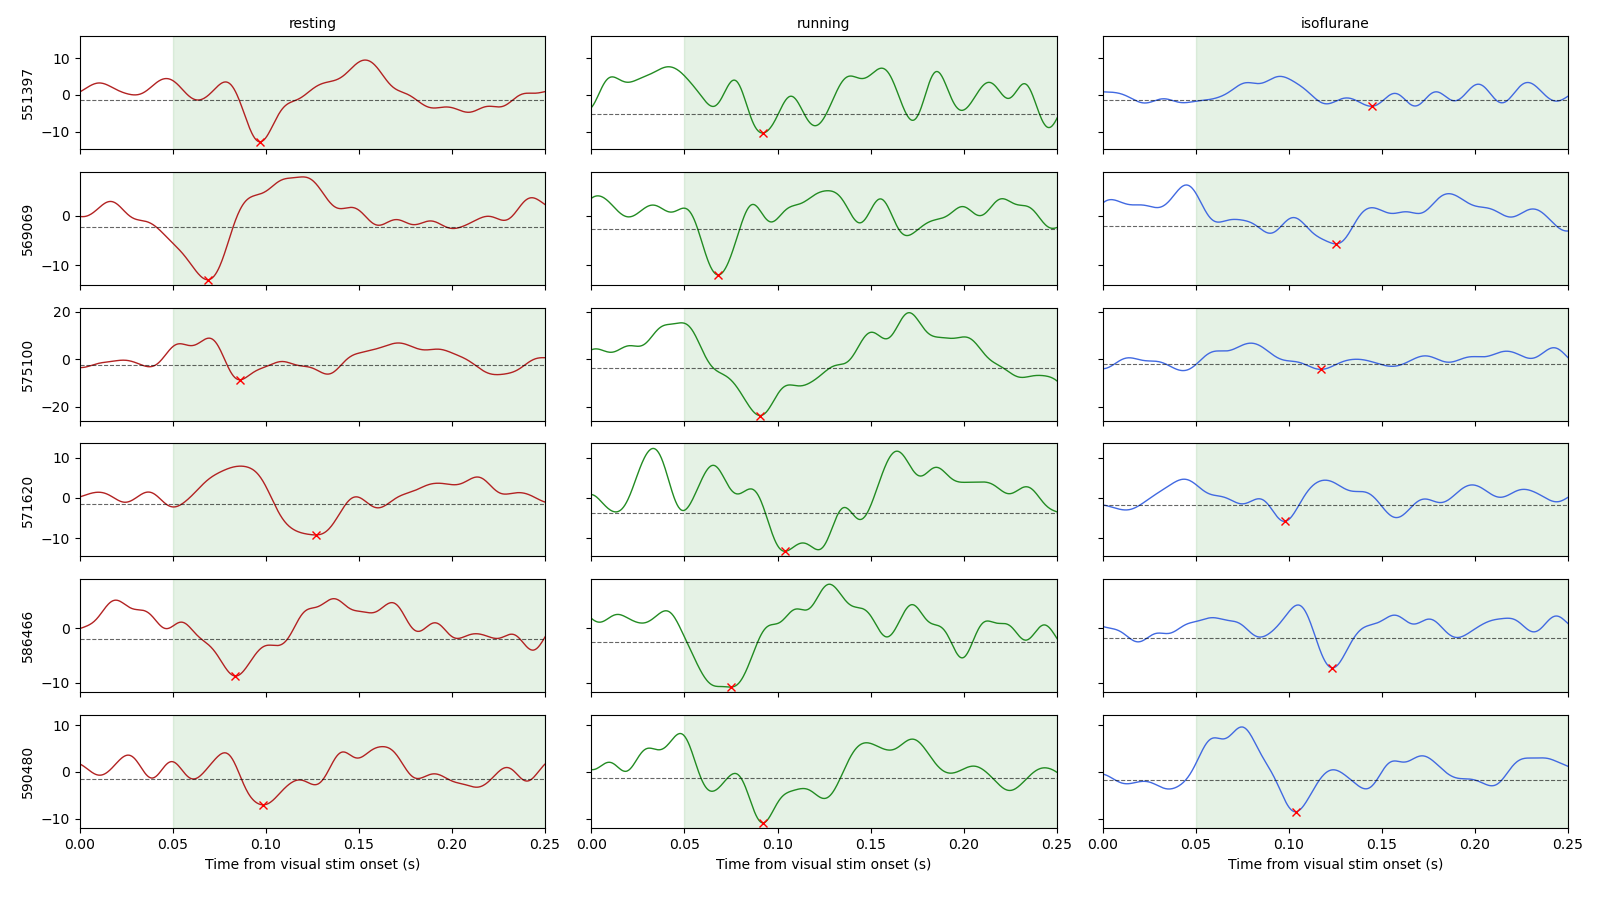

In [100]:
## Show only largest negative peak ##
fig = plt.figure(figsize=(16, 9))
gs = fig.add_gridspec(nrows=len(vis_EEG_traces), ncols=1, left=0.05, right=0.98, hspace=0.2, top=0.96, bottom=0.08)

for ii, (mousei, statedata) in enumerate(vis_EEG_traces.items()):
    subaxs = gs[ii].subgridspec(nrows=1, ncols=len(pkstates), wspace=0.1).subplots(sharex=True, sharey=True)
    subaxs[0].set_ylabel(mousei)
    for ax, (statei, datai) in zip(subaxs, statedata.items()):
        ax.axvspan(0.05, 0.25, color='g', alpha=0.1)
        timex = datai[0]
        
        ## Apply a bandpass filter ##
        filtb, filta = signal.butter(3, ffreqs/(2500/2), btype='bandpass')
        visch = np.mean(signal.filtfilt(filtb, filta, datai[1], axis=0), axis=1)
        blmean = np.mean(visch[timex < 0])
        blstd = np.std(visch[timex < 0])

        ## Find peaks in peak_win ##
        sinds = np.nonzero((timex > peak_win[0]) & (timex < peak_win[1]))[0]
        npeaks, npkinfo = signal.find_peaks(-visch[sinds], height=blmean + std_mult*blstd)
#         if len(npeaks) == 0:
#             npeaks, npkinfo = signal.find_peaks(-visch[sinds], height=blmean + blstd)
        N1ind = npeaks[np.argmin(visch[sinds[npeaks]])]

        ax.plot(timex, visch, color=state_colors[statei], linewidth=1)
        ax.axhline(blmean - std_mult*blstd, color='k', linewidth=0.8, linestyle='dashed', alpha=0.6)
        ax.plot(timex[sinds[N1ind]], visch[sinds[N1ind]], 'rx')
        if ii < len(vis_EEG_traces) - 1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel('Time from visual stim onset (s)')
        
        if ii == 0:
            ax.set_title(statei)

    ax.set_xlim(plot_win)
    
## Save ##
figname = 'find_N1_allbestsubjects.png'
# fig.savefig(os.path.join(plotsdir, figname), transparent=False)

## Plot all subjects, ERPs with error bars

In [135]:
tuple(np.argwhere(axlocs == 0)[0])

(0, 0)

## Load all EEG traces and calculate time-freq

In [11]:
## parameters ##
apply_car = True
chtrials = 'resting' # choose: 'resting', 'running', or 'all'
test_states = ['awake', 'isoflurane', 'urethane', 'burst_suppression']
test_freqs = np.arange(1., 101., 2.)
test_ncycles = test_freqs / 5.  # different number of cycle per frequency

In [12]:
start = time.time()
EEG_traces = {}
visEEG_trace = {}
visEEG_blpower = {}
for mouse_num, mdata in multi_sub_dict.items():
    print('{}'.format(mouse_num))
    substart = time.time()
    evoked_data_folder = os.path.join(mdata['exp'].data_folder, 'evoked_data')
    
    if mdata['exp'].mouse not in EEG_traces.keys():
        EEG_traces[mdata['exp'].mouse] = {}
        visEEG_trace[mdata['exp'].mouse] = {}
        visEEG_blpower[mdata['exp'].mouse] = {}
    
    ## Grab exp metadata from Zap_Zip-log_exp ##
    exp_meta = vismetadata[vismetadata['Mouse'] == mouse_num].squeeze()
    badchstr = exp_meta['Bad chs'].replace(' ','')
    bad_chs = []
    for char in badchstr.split(','):
        if char.isdecimal():
            bad_chs.append(int(char))
    
    ## Load stim log, includes running speed info ##
    stim_log = pd.read_csv(mdata['exp'].stimulus_log_file)

    ## Load EEG traces ##
    all_EEG_traces = np.load(os.path.join(evoked_data_folder, 'event_EEGtraces.npy'))
    EEG_event_timestamps = np.load(os.path.join(evoked_data_folder, 'event_EEGtraces_times.npy'))
    eeg_chs = np.arange(0, all_EEG_traces.shape[1])
    GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])
    
    ## Get evoked traces ##
    print(' Getting evoked EEG traces...')
    for statei in mdata['states'].keys():
        if statei not in test_states:
            continue
        
        sweeps = mdata['states'][statei]
        if not sweeps:
            continue
            
        if statei == 'awake':
            substates = ['resting', 'running']
            for substatei in substates:
                state_event_inds = []
                for sweepi in sweeps:
                    eventinds = get_stim_event_inds(stim_log, 'circle', 'white', sweepi, trials=substatei)
                    if len(eventinds) == 0:
                        continue
                    state_event_inds.append(eventinds)
                state_event_inds = np.concatenate(state_event_inds)
                event_traces = all_EEG_traces[:, :, state_event_inds]
                ## Apply common avg ##
                if apply_car:
                    event_traces = event_traces - np.mean(event_traces[:, GOOD_CHS, :], axis=1)[:,None,:]
                EEG_traces[mdata['exp'].mouse][substatei] = [EEG_event_timestamps, event_traces, GOOD_CHS]
                visEEG_trace[mdata['exp'].mouse][substatei] = [EEG_event_timestamps, event_traces[:, 4, :]]
                ## Calculate power ##
                power = tfr_array_morlet(
                    event_traces.T, sfreq=2500, freqs=test_freqs, n_cycles=test_ncycles, output='avg_power',
                    n_jobs=5, verbose='WARNING')
                ## INPUT (n_epochs, n_channels, n_times), OUTPUT (n_chans, n_freqs, n_times) ##
                mne.baseline.rescale(power, EEG_event_timestamps, (-1.8, -0.5), mode='logratio', copy=False, verbose='WARNING')
                visEEG_blpower[mdata['exp'].mouse][substatei] = power[4, :, :]
                print('  {} power: min={:.2f}, max={:.2f}'.format(substatei, np.min(power[4,:,:]), np.max(power[4,:,:])))
        else:
            state_event_inds = []
            for sweepi in sweeps:
                eventinds = get_stim_event_inds(stim_log, 'circle', 'white', sweepi, trials=chtrials)
                if len(eventinds) == 0:
                    continue
                state_event_inds.append(eventinds)
            state_event_inds = np.concatenate(state_event_inds)
            event_traces = all_EEG_traces[:, :, state_event_inds]
            ## Apply common avg ##
            if apply_car:
                event_traces = event_traces - np.mean(event_traces[:, GOOD_CHS, :], axis=1)[:,None,:]
            EEG_traces[mdata['exp'].mouse][statei] = [EEG_event_timestamps, event_traces, GOOD_CHS]
            visEEG_trace[mdata['exp'].mouse][statei] = [EEG_event_timestamps, event_traces[:, 4, :]]
            ## Calculate power ##
            power = tfr_array_morlet(event_traces.T, sfreq=2500, freqs=test_freqs, n_cycles=test_ncycles, output='avg_power',
                n_jobs=5, verbose='WARNING')
            mne.baseline.rescale(power, EEG_event_timestamps, (-1.8, -0.5), mode='logratio', copy=False, verbose='WARNING')
            visEEG_blpower[mdata['exp'].mouse][statei] = power[4, :, :]
            print('  {} power: min={:.2f}, max={:.2f}'.format(statei, np.min(power[4,:,:]), np.max(power[4,:,:])))

    del stim_log, all_EEG_traces, EEG_event_timestamps
    subend = time.time()
    print(' Time = {:.2f} mins\n'.format((subend-substart)/60))
end = time.time()
print('Time to load all subjects: {:.2f} mins'.format((end-start)/60))

551397
 Getting evoked EEG traces...
  resting power: min=-0.40, max=0.51
  running power: min=-0.72, max=0.81
  isoflurane power: min=-0.40, max=0.60
 Time = 1.24 mins

569062
 Getting evoked EEG traces...
  resting power: min=-0.53, max=0.20
  running power: min=-1.07, max=0.47
  isoflurane power: min=-0.46, max=0.22
 Time = 1.19 mins

569068
 Getting evoked EEG traces...
  resting power: min=-0.61, max=0.98
  running power: min=-0.51, max=1.46
  isoflurane power: min=-0.55, max=0.62
 Time = 1.19 mins

569069
 Getting evoked EEG traces...
  resting power: min=-0.54, max=0.32
  running power: min=-0.61, max=0.61
  isoflurane power: min=-0.53, max=0.63
 Time = 1.13 mins

569064
 Getting evoked EEG traces...
  resting power: min=-0.48, max=0.31
  running power: min=-2.83, max=1.15
  isoflurane power: min=-0.53, max=0.64
 Time = 1.22 mins

569073
 Getting evoked EEG traces...
  resting power: min=-0.61, max=0.22
  running power: min=-1.04, max=1.11
  isoflurane power: min=-0.62, max=0.28

### Plotting single subject

<IPython.core.display.Javascript object>


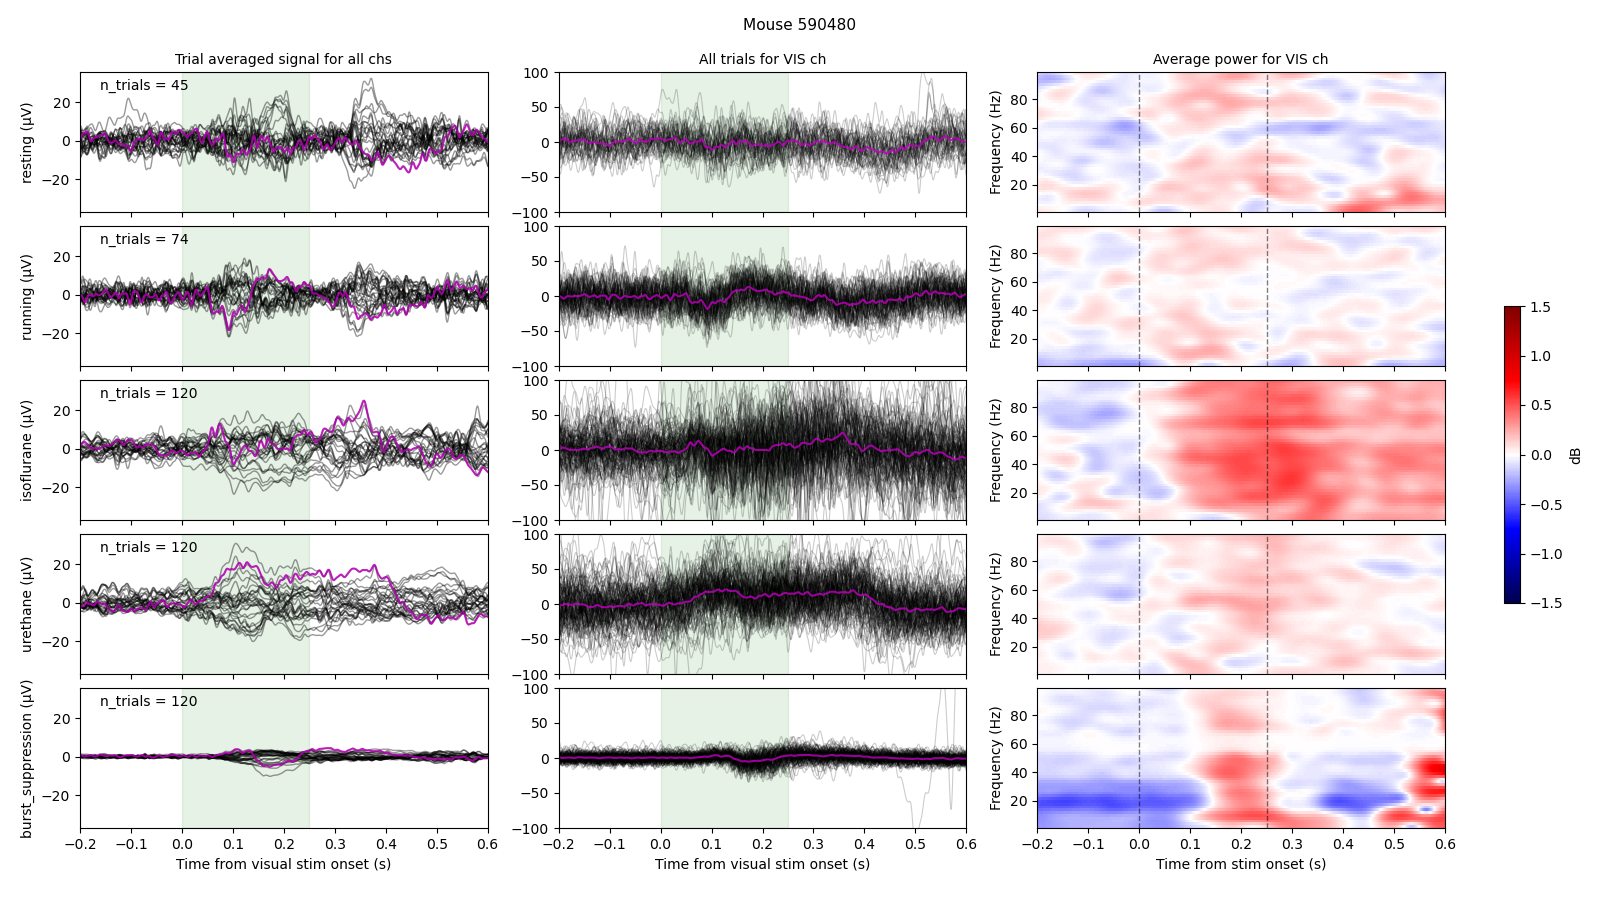

In [36]:
mouse_num = '590480'
pwin = [-0.2, 0.6]

fig = plt.figure(figsize=(16, 9))
gs = fig.add_gridspec(nrows=1, ncols=4, left=0.05, right=0.99, wspace=0.22, width_ratios=[6,6,6,1], top=0.92, bottom=0.08)
eegaxs = gs[0].subgridspec(nrows=(len(EEG_traces[mouse_num])), ncols=1, hspace=0.1).subplots(sharex=True, sharey=True)
visaxs = gs[1].subgridspec(nrows=(len(EEG_traces[mouse_num])), ncols=1, hspace=0.1).subplots(sharex=True, sharey=True)
powaxs = gs[2].subgridspec(nrows=(len(EEG_traces[mouse_num])), ncols=1, hspace=0.1).subplots(sharex=True, sharey=True)

for rowi, (statei, datai) in enumerate(EEG_traces[mouse_num].items()):
    timex = datai[0]
    good_chs = datai[2]
    alltraces = datai[1]
    visch = visEEG_trace[mouse_num][statei][1]
    vispow = visEEG_blpower[mouse_num][statei]

    ## Plot trial average for all good chs ##
    eegaxs[rowi].axvspan(0, 0.25, color='g', alpha=0.1)
    eegaxs[rowi].plot(timex, np.mean(alltraces, 2)[:, good_chs], 'k', linewidth=1, alpha=0.4)
    eegaxs[rowi].plot(timex, np.mean(visch, axis=1), 'm', linewidth=1.5, alpha=0.8)
    eegaxs[rowi].set_ylabel('{} (\u03bcV)'.format(statei))
    eegaxs[rowi].annotate(
        'n_trials = {:d}'.format(alltraces.shape[2]), xy=(0.05, 0.95), xycoords='axes fraction',
        fontsize=10, ha='left', va='top'
    )
    
    ## Plot all trials for ch4 ##
    visaxs[rowi].axvspan(0, 0.25, color='g', alpha=0.1)
    visaxs[rowi].plot(timex, visch, 'k', linewidth=0.8, alpha=0.2)
    visaxs[rowi].plot(timex, np.mean(visch, axis=1), 'm', linewidth=1.5, alpha=0.8)
    
    ## Plot power of ch 4 ##
    im = powaxs[rowi].imshow(
        vispow, cmap='seismic', interpolation='none', aspect='auto', origin='lower', vmin=-1.5, vmax=1.5,
        extent=[timex[0], timex[-1], test_freqs[0], test_freqs[-1]]
    )
    powaxs[rowi].axvline(0, color='k', linestyle='dashed', linewidth=1, alpha=0.5)
    powaxs[rowi].axvline(0.25, color='k', linestyle='dashed', linewidth=1, alpha=0.5)
    powaxs[rowi].set_ylabel('Frequency (Hz)')
    
eegaxs[rowi].set_xlim(pwin)
eegaxs[rowi].set_xlabel('Time from visual stim onset (s)')
eegaxs[0].set_title('Trial averaged signal for all chs')
visaxs[rowi].set_xlim(pwin)
visaxs[rowi].set_ylim([-100, 100])
visaxs[rowi].set_xlabel('Time from visual stim onset (s)')
visaxs[0].set_title('All trials for VIS ch')
powaxs[rowi].set_xlim(pwin)
powaxs[rowi].set_xlabel('Time from stim onset (s)')
powaxs[0].set_title('Average power for VIS ch')

## Add power colorbar ##
cbax = plt.subplot(gs[3], position=[0.94, 0.33, 0.01, 0.33])
cb = Colorbar(ax=cbax, mappable=im, orientation='vertical')
cb.set_label('dB')

plt.suptitle('Mouse {}'.format(mouse_num), fontsize=11)

## Save ##
figname = '{}_EEGsignals_allstates.png'.format(mouse_num)
# fig.savefig(os.path.join(plotsdir, figname), transparent=False)

## Plot all subjects

## Time-frequency analysis

#### Frequency: linear scale

In [36]:
plevel = 'medium'
pstate = 'anesthetized' # 'awake' 'anesthetized'

test_freqs = np.arange(1., 101., 2.)
test_ncycles = test_freqs / 5.  # different number of cycle per frequency

timex = EEG_traces[plevel][pstate][0]
traces = EEG_traces[plevel][pstate][1][:, GOOD_CHS, :]

start = time.time()
power = tfr_array_morlet(
    traces.T, sfreq=mdata['exp'].ephys_params['EEG']['sample_rate'],
    freqs=test_freqs, n_cycles=test_ncycles, output='avg_power'
)
## (n_chans, n_freqs, n_times) ##

## Baseline adjust power ##
blpower = mne.baseline.rescale(power, timex, (-1.8, -0.5), mode='logratio', copy=True)
end = time.time()
print('Time to analyze: {:.2f} min'.format((end-start)/60))

Applying baseline correction (mode: logratio)
Time to analyze: 1.56 min


<IPython.core.display.Javascript object>


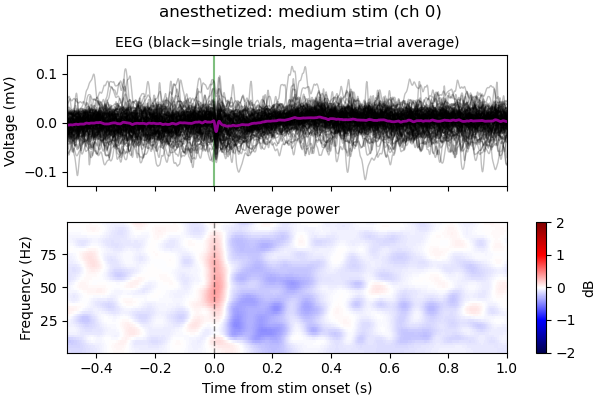

In [41]:
pch = 0
pwin = [-0.5, 1.0]

if pch in GOOD_CHS:
    chind = np.nonzero(GOOD_CHS == pch)[0][0]

    fig, axs = plt.subplots(2, 1, figsize=(6,4), sharex=True, constrained_layout=True)

    ## Plot average across trials ##
    axs[0].axvline(0, color='g', alpha=0.5)
    axs[0].plot(timex, traces[:, chind, :]/1E3, 'k', linewidth=1, alpha=0.25)
    axs[0].plot(timex, np.mean(traces[:, chind, :], axis=1)/1E3, 'm', linewidth=2, alpha=0.75)
    axs[0].set_ylabel('Voltage (mV)')
    axs[0].set_title('EEG (black=single trials, magenta=trial average)')

    ## Plot power ##
    im = axs[1].imshow(
        blpower[chind,:,:], cmap='seismic', interpolation='none', aspect='auto', origin='lower', vmin=-2, vmax=2,
        extent=[timex[0], timex[-1], test_freqs[0], test_freqs[-1]]
    )
    axs[1].axvline(0, color='k', linestyle='dashed', linewidth=1, alpha=0.5)
    axs[1].set_xlim(pwin)
    cbar = fig.colorbar(im)
    cbar.set_label('dB')
    axs[1].set_ylabel('Frequency (Hz)')
    axs[1].set_xlabel('Time from stim onset (s)')
    axs[1].set_title('Average power')

    plt.suptitle('{}: {} stim (ch {:d})'.format(pstate, plevel, pch))

    ## Save ##
    figname = 'EEGpower_{}_{}_{}_{}_ch{:d}.png'.format(mouse_num, group, pstate, plevel, pch)
#     fig.savefig(os.path.join(plotsdir, figname), transparent=True)
else:
    print('Chosen channel is bad')